In [1]:
import bw2data, bw2calc, bw2io
from edges import EdgeLCIA, get_available_methods
from bw2analyzer.contribution import ContributionAnalysis

In [2]:
bw2data.projects.set_current("bw25_ei310")
act = bw2data.Database("ecoinvent-3.10-cutoff").random()
#act = [a for a in bw2data.Database("ecoinvent-3.10-cutoff") if "NMC" in #a["name"]][0]
act

'market for acetic acid, without water, in 98% solution state' (kilogram, GLO, None)

In [3]:
[m for m in get_available_methods() if "ImpactWorld" in str(m)]

[('ImpactWorld+ 2.1', 'Freshwater acidification', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Land occupation, biodiversity', 'damage'),
 ('ImpactWorld+ 2.1', 'Land occupation, biodiversity', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Land transformation, biodiversity', 'damage'),
 ('ImpactWorld+ 2.1', 'Land transformation, biodiversity', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Marine eutrophication', 'damage'),
 ('ImpactWorld+ 2.1', 'Marine eutrophication', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Terrestrial acidification', 'damage'),
 ('ImpactWorld+ 2.1', 'Terrestrial acidification', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Thermally polluted water', 'damage'),
 ('ImpactWorld+ 2.1', 'Thermally polluted water', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Water availability, freshwater ecosystem', 'damage'),
 ('ImpactWorld+ 2.1', 'Water 

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|████████████████████████████████████| 3676/3676 [00:00<00:00, 90432.87it/s]


Handling static regions...


100%|████████████████████████████████████| 1255/1255 [00:00<00:00, 42592.96it/s]


Handling dynamic regions...


100%|█████████████████████████████████████| 1255/1255 [00:00<00:00, 2551.13it/s]


Handling unmatched locations...


100%|██████████████████████████████████████| 311/311 [00:00<00:00, 18984.00it/s]


Handling remaining exchanges...


100%|███████████████████████████████████████| 311/311 [00:00<00:00, 1496.92it/s]


+---------------------------+-----------------------------------------------+
|          Activity         | market for acetic acid, without water, in 98% |
|                           |                 solution state                |
|        Method name        |   ('ImpactWorld+ 2.1', 'Land transformation,  |
|                           |           biodiversity', 'midpoint')          |
|         Data file         |     ImpactWorld+ 2.1_Land transformation,     |
|                           |             biodiversity_midpoint             |
|    Unique CFs in method   |                      2258                     |
|      Unique CFs used      |                      433                      |
| CFs without eligible exc. |                      3148                     |
|     Exc. characterized    |                      2417                     |
|    Exc. uncharacterized   |                       0                       |
+---------------------------+-----------------------------------

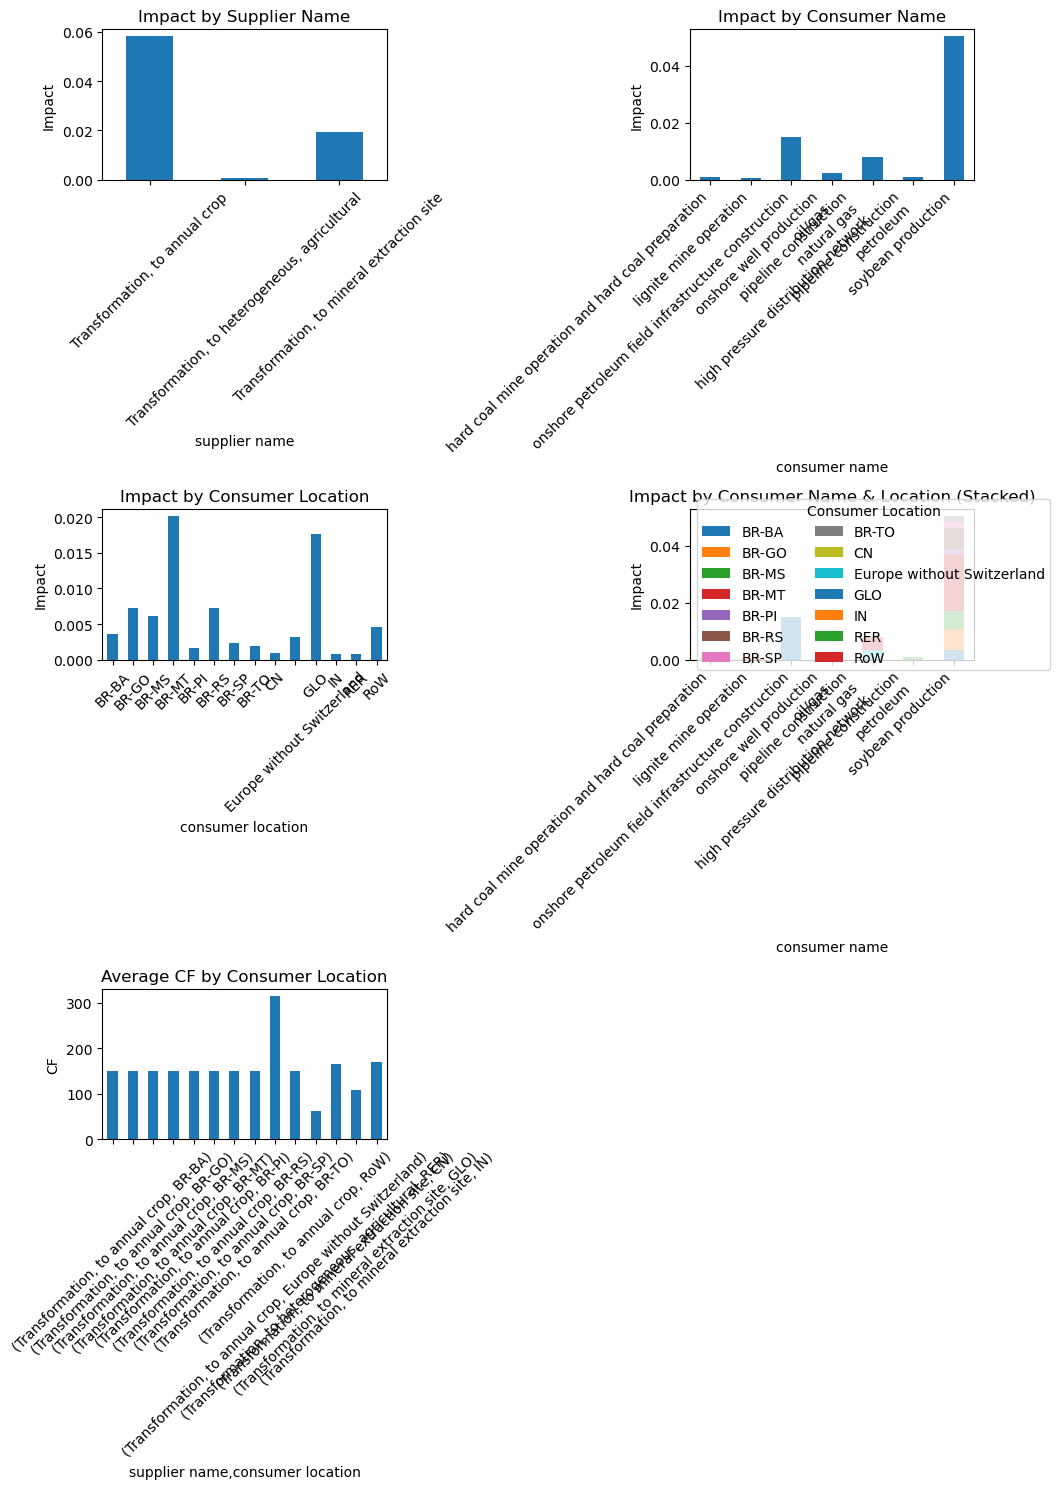

In [5]:
import matplotlib.pyplot as plt
#method = ('GeoPolRisk', '2024')
# method = ('ImpactWorld+ 2.1', 'Land transformation, biodiversity', 'midpoint')
methods = [m for m in get_available_methods() if "ImpactWorld+" in str(m) and "midpoint" in str(m)]
methods = [('ImpactWorld+ 2.1', 'Land transformation, biodiversity', 'midpoint'),]
for method in methods:
    LCA = EdgeLCIA({act: 1}, method)
    LCA.lci()
    LCA.lcia()
    df = LCA.generate_cf_table()

    if "water" in str(method):
        cutoff = 0.05
        continue
    else:
        cutoff = 0.01

    # remove rows for which "amount" is below the cutoff
    total = df["impact"].sum()
    df = df[df["impact"] > cutoff * total]

    # Plotting
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    # 1. Bar plot of "amount" by "supplier name"
    df.groupby("supplier name")["impact"].sum().plot(kind="bar", ax=axes[0, 0])
    axes[0, 0].set_title("Impact by Supplier Name")
    axes[0, 0].set_ylabel("Impact")
    axes[0, 0].tick_params(axis="x", rotation=45)

    # 2. Bar plot of "amount" by "consumer name"
    df.groupby("consumer name")["impact"].sum().plot(kind="bar", ax=axes[0, 1])
    axes[0, 1].set_title("Impact by Consumer Name")
    axes[0, 1].set_ylabel("Impact")
    axes[0, 1].set_xticklabels(
        [label.get_text().replace(", ", "\n") for label in axes[0, 1].get_xticklabels()],
        rotation=45,
        ha="right",
    )

    # 3. Bar plot of "amount" by "consumer location"
    df.groupby("consumer location")["impact"].sum().plot(kind="bar", ax=axes[1, 0])
    axes[1, 0].set_title("Impact by Consumer Location")
    axes[1, 0].set_ylabel("Impact")
    axes[1, 0].tick_params(axis="x", rotation=45)

    # 4. Stacked bar plot for "amount" by "consumer name" and "consumer location"
    df_grouped = df.groupby(["consumer name", "consumer location"])["impact"].sum().unstack()
    df_grouped.plot(kind="bar", stacked=True, ax=axes[1, 1])
    axes[1, 1].set_title("Impact by Consumer Name & Location (Stacked)")
    axes[1, 1].set_ylabel("Impact")
    axes[1, 1].set_xticklabels(
        [label.get_text().replace(", ", "\n") for label in axes[1, 1].get_xticklabels()],
        rotation=45,
        ha="right",
    )
    axes[1, 1].legend(title="Consumer Location", loc="center left", ncol=2)

    # 5. Bar plot of average "CF" by "consumer location"
    df.groupby(["supplier name", "consumer location"])["CF"].mean().plot(kind="bar", ax=axes[2, 0])
    axes[2, 0].set_title("Average CF by Consumer Location")
    axes[2, 0].set_ylabel("CF")
    axes[2, 0].tick_params(axis="x", rotation=45)

    # remove last subplot
    fig.delaxes(axes[2, 1])

    plt.tight_layout()
    plt.show()

    

  #LCA.score

In [9]:
df["impact"].sum()

0.07824615248185379

In [7]:
df.loc[df["consumer name"] == "soybean production"]

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
1409,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-MT,0.000133,150.878435,0.020124
1427,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-RS,0.000048,150.878435,0.007286
1436,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-GO,0.000048,150.878435,0.007317
1437,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-SP,0.000015,150.878435,0.002307
1443,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-PI,0.000011,150.878435,0.001602
1447,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-MS,0.000041,150.878435,0.006151
1454,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-TO,0.000013,150.878435,0.001909
1470,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-BA,0.000024,150.878435,0.003546


In [10]:
df.sort_values("amount", ascending=False)

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
1790,"Transformation, to mineral extraction site","(natural resource, land)",onshore petroleum field infrastructure constru...,onshore petroleum field infrastructure,GLO,0.000138,108.941609,0.015058
1409,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-MT,0.000133,150.878435,0.020124
1436,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-GO,0.000048,150.878435,0.007317
1427,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-RS,0.000048,150.878435,0.007286
1447,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-MS,0.000041,150.878435,0.006151
1419,"Transformation, to annual crop","(natural resource, land)","pipeline construction, natural gas, high press...","pipeline, natural gas, high pressure distribut...",RoW,0.000031,150.708486,0.004637
1470,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-BA,0.000024,150.878435,0.003546
1793,"Transformation, to mineral extraction site","(natural resource, land)","onshore well production, oil/gas","onshore well, oil/gas",GLO,0.000023,108.941609,0.002548
1437,"Transformation, to annual crop","(natural resource, land)",soybean production,soybean,BR-SP,0.000015,150.878435,0.002307
1731,"Transformation, to heterogeneous, agricultural","(natural resource, land)","pipeline construction, petroleum","pipeline, petroleum",RER,0.000013,62.932928,0.000828


In [8]:
df["CF"].unique()

array([150.87843498, 150.70848584, 314.37457713,  62.9329279 ,
       166.60068556, 108.9416093 , 170.95081809])

In [16]:
df.groupby(["supplier name", "consumer location"])["CF"].mean()

supplier name   consumer location         
Sulfur dioxide  Europe without Switzerland     4.368280
                GLO                            2.481095
                RU                            24.675845
Name: CF, dtype: float64

In [21]:
list(LCA.demand.keys())[0]

124526838126026753

In [1]:
from constructive_geometries import geomatcher
geo = geomatcher.Geomatcher()

geo.within("PG", biggest_first=False)

['PG', ('ecoinvent', 'UN-MELANESIA'), ('ecoinvent', 'UN-OCEANIA'), 'GLO']

In [2]:
geo.contained("PG", biggest_first=False)

['PG']

In [6]:
set([x["supplier"]["name"] for x in LCA.ignored_method_exchanges])

{'Water',
 'Water, cooling, unspecified natural origin',
 'Water, in air',
 'Water, lake',
 'Water, river',
 'Water, turbine use, unspecified natural origin',
 'Water, unspecified natural origin',
 'Water, well, in ground'}

In [7]:
LCA.generate_cf_table()

Matrix type: biosphere


,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
0,"Water, cooling, unspecified natural origin","(natural resource, in water)","particleboard production, uncoated, from virgi...","particleboard, uncoated",RoW,6.544631e-11,20.179399,1.320667e-09
1,"Water, cooling, unspecified natural origin","(natural resource, in water)","heat and power co-generation, lignite","electricity, high voltage",SI,1.453419e-07,1.087201,1.580158e-07
2,"Water, cooling, unspecified natural origin","(natural resource, in water)",atrazine production,atrazine,RoW,4.228744e-12,19.819034,8.380961e-11
3,"Water, cooling, unspecified natural origin","(natural resource, in water)","sheet rolling, copper","sheet rolling, copper",RoW,1.290820e-10,19.819034,2.558280e-09
4,"Water, cooling, unspecified natural origin","(natural resource, in water)","phosphoric acid production, dihydrate process","phosphoric acid, fertiliser grade, without wat...",MA,5.123237e-08,54.031045,2.768139e-06
...,...,...,...,...,...,...,...,...
4923,"Water, in air","(natural resource, in air)",soy-based resin production,"polyester resin, unsaturated",US,4.729868e-16,9.087076,4.298067e-15
4924,"Water, in air","(natural resource, in air)",soy-based resin production,"polyester resin, unsaturated",RoW,1.378576e-15,20.175187,2.781303e-14
4925,"Water, in air","(natural resource, in air)",clinker production,clinker,RoW,1.625316e-09,20.627229,3.352577e-08
4926,"Water, in air","(natural resource, in air)","particleboard production, cement bonded","particleboard, cement bonded",RER,8.635607e-19,6.750246,5.829247e-18


In [7]:
LCA.ignored_locations

set()

In [9]:
method = ('AWARE 1.2c', 'Country', 'mixed', 'yearly')
convmethod = (
  # 'ecoinvent-3.10',
  'EF v3.1 EN15804',
  'water use',
  'user deprivation potential (deprivation-weighted water consumption)')

In [10]:
import bw2calc

convLCA = bw2calc.LCA({act: 1}, convmethod)
convLCA.lci()
convLCA.lcia()
convLCA.score

/opt/homebrew/Caskroom/miniforge/base/envs/bw2/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.83e+13)
  warnings.warn(msg, UmfpackWarning)


0.06176615560312869